<a href="https://colab.research.google.com/github/alauzon13/alauzon13.github.io/blob/main/Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from numpy import arange
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
import math
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso



In [ ]:
from google.colab import files
files.upload()

Saving FINAL_country_feature_data - FINAL_country_feature_data.csv to FINAL_country_feature_data - FINAL_country_feature_data.csv


{'FINAL_country_feature_data - FINAL_country_feature_data.csv': b'Country,R&D Expenditure (% of GDP),Number of Researchers per Capita,Education Quality (STEM graduates),Number of Patents Filed per Capita,Number of Unicorn Startups,High-tech Exports (% of total exports),Government Spending on Innovation,Venture Capital Investments,Public-Private Collaboration Index Encoded,Infrastructure Readiness Encoded,Knowledge Diffusion Encoded,Tax Incentives for R&D Encoded,Innovation Score\r\nAustralia,1.85,5.7,113.03,2.69,6.39,17.58,1.19,1844.44,2,3,2,2,48.1\r\nCanada,1.7,5.94,119.44,3.04,9.67,20.55,1.22,3465.91,2,3,2,2,52.9\r\nChina,2.32,5.92,146.37,8.81,86.26,28.26,1.51,23800,2,3,2,2,56.3\r\nEstonia,1.62,4.4,80.29,1.44,2.5,18,0.77,581.11,2,3,2,2,52.3\r\nFinland,2.89,7.43,160.52,4.69,6.56,24.6,1.35,1552.78,3,3,3,3,59.4\r\nGermany,2.93,6.35,141.91,6.9,13.25,25.57,1.56,4476.32,3,3,3,2,58.1\r\nIndia,0.7,1.26,58.09,0.59,32.58,9.91,0.62,5628.95,1,1,1,1,38.3\r\nNew Zealand,1.41,5.42,74.8,1.85,3,15.38

In [ ]:
df = pd.read_csv("FINAL_country_feature_data.csv", low_memory = False, encoding = 'latin2')
df.head()

,Country,R&D Expenditure (% of GDP),Number of Researchers per Capita,Education Quality (STEM graduates),Number of Patents Filed per Capita,Number of Unicorn Startups,High-tech Exports (% of total exports),Government Spending on Innovation,Venture Capital Investments,Public-Private Collaboration Index Encoded,Infrastructure Readiness Encoded,Knowledge Diffusion Encoded,Tax Incentives for R&D Encoded,Innovation Score
0,Australia,1.85,5.70,113.03,2.69,6.39,17.58,1.19,1844.44,2,3,2,2,48.1
1,Canada,1.70,5.94,119.44,3.04,9.67,20.55,1.22,3465.91,2,3,2,2,52.9
2,China,2.32,5.92,146.37,8.81,86.26,28.26,1.51,23800.00,2,3,2,2,56.3
3,Estonia,1.62,4.40,80.29,1.44,2.50,18.00,0.77,581.11,2,3,2,2,52.3
4,Finland,2.89,7.43,160.52,4.69,6.56,24.60,1.35,1552.78,3,3,3,3,59.4


# EDA

In [ ]:
# replace spaces with _ for data wrangling purposes
df = df.rename(columns=lambda x: x.replace(' ', '_'))
df = df.rename(columns={'R&D_Expenditure_(%_of_GDP)': 'RD_Expenditure'})
df = df.rename(columns={'High-tech_Exports_(%_of_total_exports)': 'High_tech_Exports'})
df = df.rename(columns={'Public-Private_Collaboration_Index_Encoded': 'Public_Private_Collaboration_Index_Encoded'})
df = df.rename(columns={'Tax_Incentives_for_R&D_Encoded': 'Tax_Incentives_for_RD_Encoded'})
df = df.rename(columns={'Education_Quality_(STEM_graduates)': 'Education_Quality'})

df.columns

Index(['Country', 'RD_Expenditure', 'Number_of_Researchers_per_Capita',
       'Education_Quality', 'Number_of_Patents_Filed_per_Capita',
       'Number_of_Unicorn_Startups', 'High_tech_Exports',
       'Government_Spending_on_Innovation', 'Venture_Capital_Investments',
       'Public_Private_Collaboration_Index_Encoded',
       'Infrastructure_Readiness_Encoded', 'Knowledge_Diffusion_Encoded',
       'Tax_Incentives_for_RD_Encoded', 'Innovation_Score'],
      dtype='object')

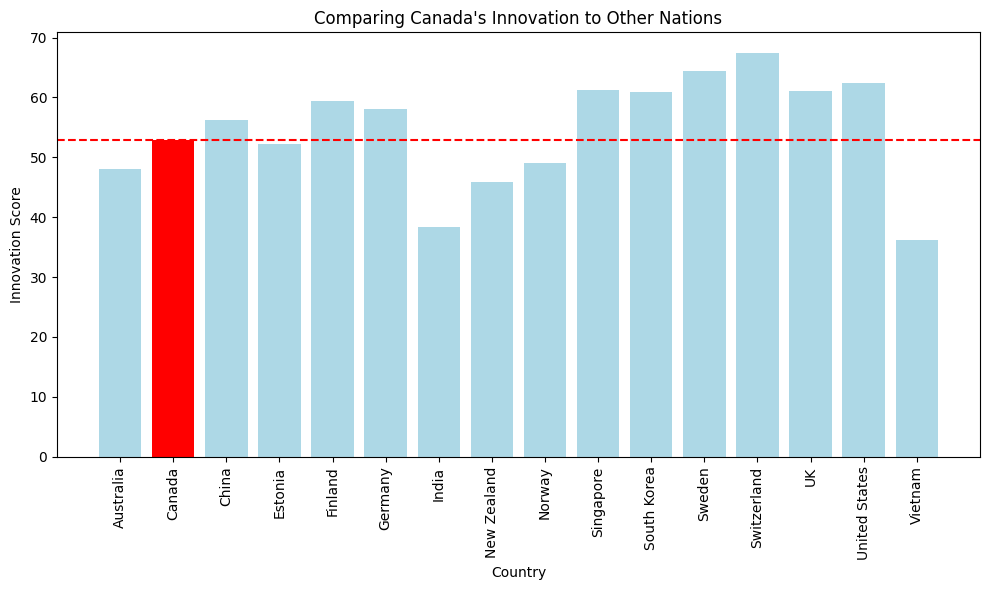

In [ ]:
# Chart Canada's innovation score compared to other countries
canada_score = df[df['Country'] == 'Canada']['Innovation_Score'].values[0]  # Get Canada's score

# Create a bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Create an array of colors, with grey for all countries except Canada
colors = ['lightblue' if country != 'Canada' else 'red' for country in df['Country']]

plt.bar(df['Country'], df['Innovation_Score'], color=colors)
plt.axhline(y=canada_score, color='r', linestyle='--', label='Canada')

plt.xlabel('Country')
plt.ylabel('Innovation Score')
plt.title('Comparing Canada\'s Innovation to Other Nations')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

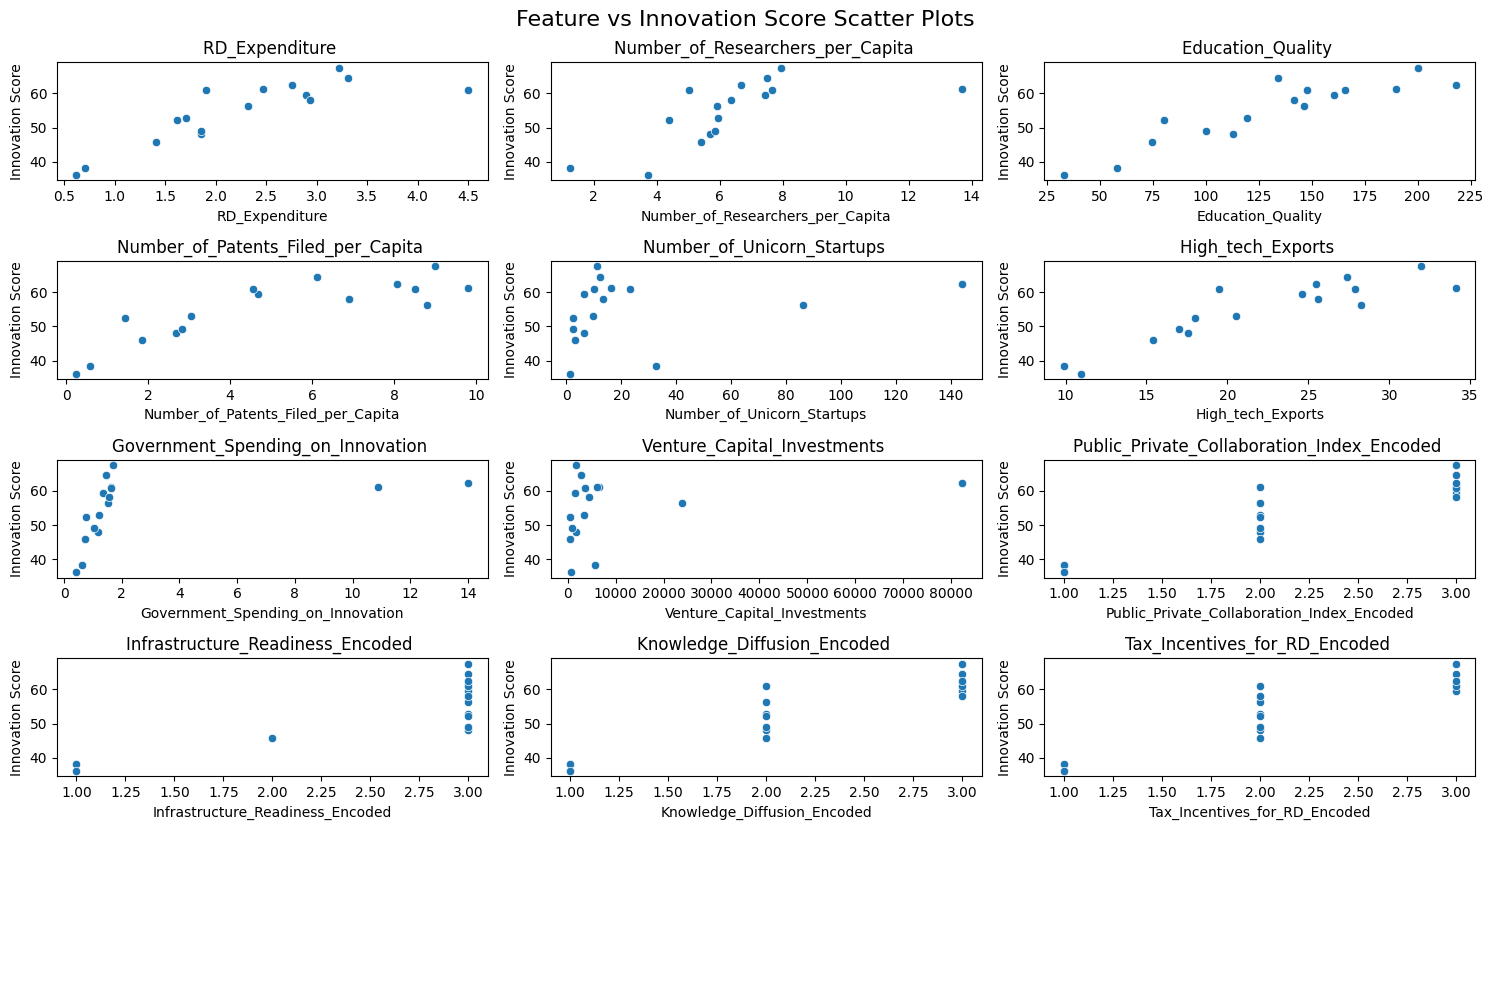

In [ ]:
# Check linearity
# Plot features v target (innovation score)
# Calculate the number of rows and columns for subplots
num_cols = 3  # Adjust as needed
num_rows = int(np.ceil((len(df.columns) - 1) / num_cols))  # Exclude target column

# Create the figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))  # Adjust size as needed
fig.suptitle('Feature vs Innovation Score Scatter Plots', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through features and create scatter plots
i = 0
for column in df.columns:
    if column != 'Innovation_Score' and column != 'Country':
        sns.scatterplot(x=column, y='Innovation_Score', data=df, ax=axes[i])
        axes[i].set_title(f'{column} ')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Innovation Score')
        i += 1

# Hide any unused subplots
for j in range(i, len(axes)):
    axes[j].axis('off')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

The results look fairly linear, but some variables could possibly be transformed. Residual plots may tell us more information.

In [ ]:
# Fit full model
model = ols('Innovation_Score ~ RD_Expenditure + \
Number_of_Researchers_per_Capita + Education_Quality + \
Number_of_Patents_Filed_per_Capita + Number_of_Unicorn_Startups + \
High_tech_Exports + Government_Spending_on_Innovation + \
Venture_Capital_Investments + C(Public_Private_Collaboration_Index_Encoded) + \
C(Infrastructure_Readiness_Encoded) + C(Knowledge_Diffusion_Encoded) + \
C(Tax_Incentives_for_RD_Encoded)', data=df).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       Innovation_Score   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     77.95
Date:                Sat, 30 Nov 2024   Prob (F-statistic):            0.00210
Time:                        19:45:53   Log-Likelihood:                -11.594
No. Observations:                  16   AIC:                             49.19
Df Residuals:                       3   BIC:                             59.23
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
def plot_residuals(model, df):
    """
    Plots residuals vs. fitted values, residuals vs. each predictor (excluding the intercept and categorical predictors),
    and a QQ plot in a grid layout.

    Args:
        model: A fitted statsmodels OLS model.
        df: The DataFrame used to fit the model.

    Returns:
        None. Displays the plots in a single figure.
    """
    residuals = model.resid
    fitted_values = model.fittedvalues

    # Get numeric predictors (excluding intercept and categorical predictors with 'C(')
    predictors = [pred for pred in model.params.index if pred != 'Intercept' and 'C(' not in pred]
    num_predictors = len(predictors)

    # Total number of plots: predictors + residuals vs. fitted values + QQ plot
    total_plots = num_predictors + 2

    # Determine grid size (e.g., 2 columns)
    cols = 2
    rows = math.ceil(total_plots / cols)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axes = axes.flatten()  # Flatten to easily index the axes
    fig.suptitle('Residual Analysis', fontsize=16, y=1.02)

    # Plot Residuals vs. Fitted Values
    ax = axes[0]
    ax.scatter(fitted_values, residuals, alpha=0.7)
    ax.set_title('Residuals vs. Fitted Values')
    ax.set_xlabel('Fitted Values')
    ax.set_ylabel('Residuals')

    # Plot Residuals vs. Each Predictor
    for i, predictor in enumerate(predictors):
        ax = axes[i + 1]
        ax.scatter(df[predictor], residuals, alpha=0.7)
        ax.set_title(f'{predictor}')
        ax.set_xlabel(predictor)
        ax.set_ylabel('Residuals')

    # QQ Plot
    ax = axes[num_predictors + 1]
    sm.qqplot(residuals, line='s', ax=ax)
    ax.set_title('Normal Q-Q Plot of Residuals')

    # Hide any unused subplots
    for i in range(total_plots, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


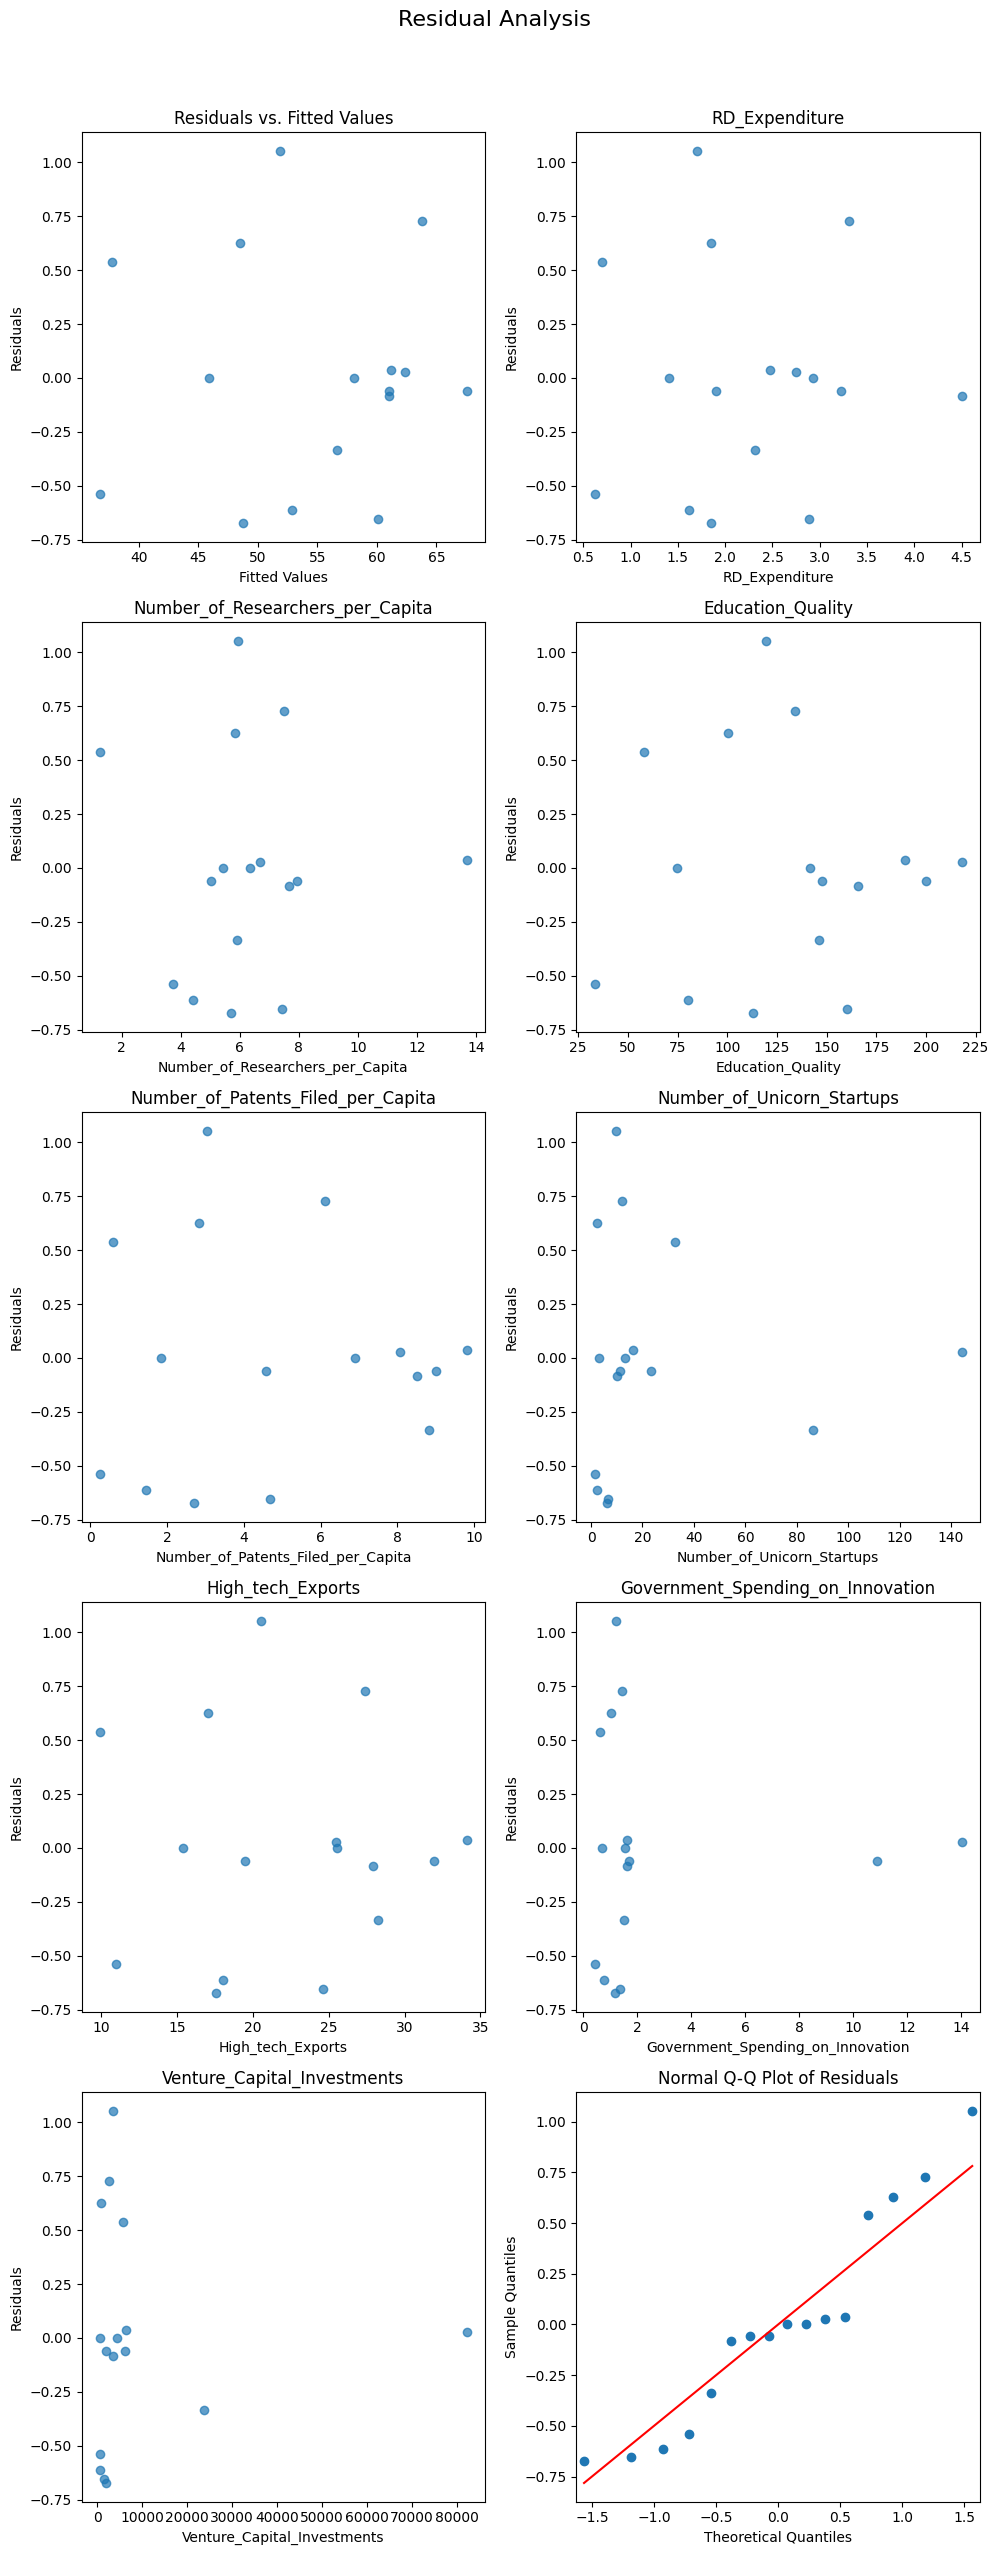

In [ ]:
plot_residuals(model, df)

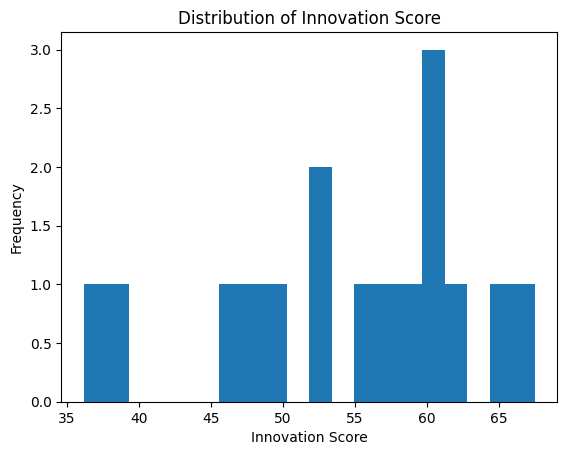

In [ ]:
# histogram of innovation score
plt.hist(df['Innovation_Score'], bins=20)
plt.xlabel('Innovation Score')
plt.ylabel('Frequency')
plt.title('Distribution of Innovation Score')
plt.show()

Takeaways from residual plots:


*   Transform predictors with non-random residual plots (government spending + VC investments)



Lambda value used for Transformation: -0.551125293017126


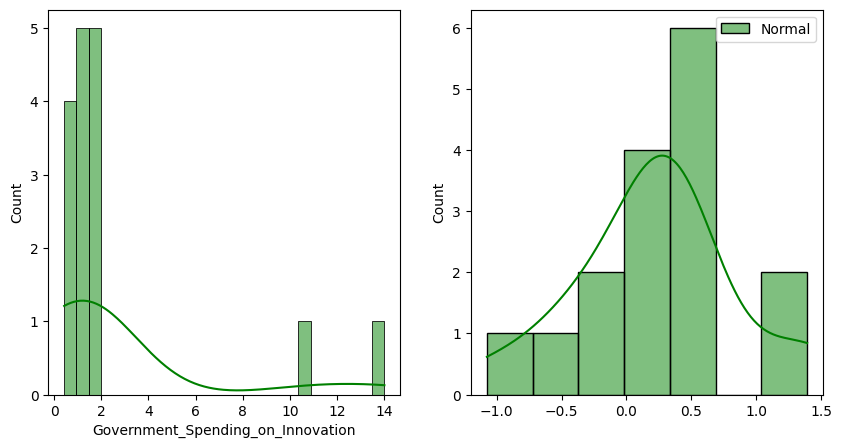

In [ ]:
# Transformations

# transformation for gov spending

# transform training data & save lambda value
transformed_innovation, lambda_innovation = stats.boxcox(df['Government_Spending_on_Innovation'])

# add transformed data to df
#df['Government_Spending_on_Innovation_Transformed'] = transformed_innovation
df['Government_Spending_on_Innovation'] = pd.to_numeric(df['Government_Spending_on_Innovation'], errors='coerce')
df['Government_Spending_on_Innovation_Transformed'] = df['Government_Spending_on_Innovation'].apply(lambda x: math.log(x) if x > 0 else np.nan)

# creating axes to draw plots
fig, ax = plt.subplots(1, 2)

# plotting the original data(non-normal) and
# fitted data (normal)
sns.histplot(df['Government_Spending_on_Innovation'],
            label = "Non-Normal", color ="green", ax = ax[0], kde=True)

sns.histplot(transformed_innovation,
            label = "Normal", color ="green", ax = ax[1], kde=True)

# adding legends to the subplots
plt.legend(loc = "upper right")

# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

print(f"Lambda value used for Transformation: {lambda_innovation}")


Lambda value used for Transformation: -0.24288626434845295


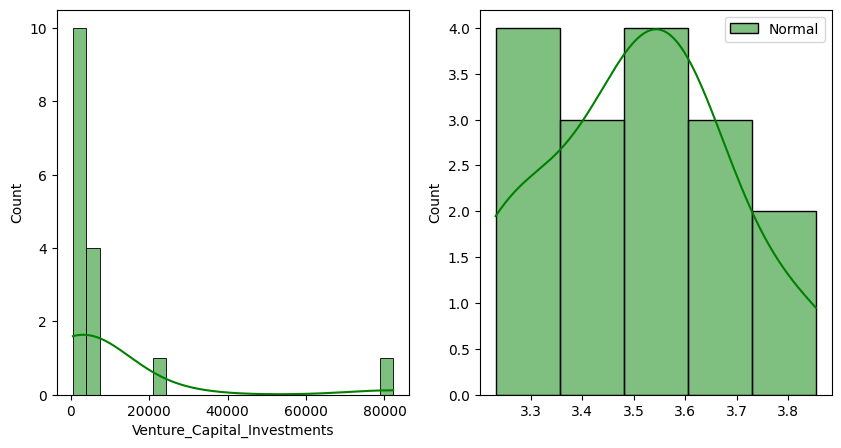

In [ ]:
# Box-cox transformation for VC investments

# transform training data & save lambda value
transformed_vc, lambda_vc = stats.boxcox(df['Venture_Capital_Investments'])

# add transformed data to df
#df['Venture_Capital_Investments_Transformed'] = transformed_vc
df['Venture_Capital_Investments'] = pd.to_numeric(df['Venture_Capital_Investments'], errors='coerce')
df['Venture_Capital_Investments_Transformed'] = df['Venture_Capital_Investments'].apply(lambda x: math.log(x) if x > 0 else np.nan)


# creating axes to draw plots
fig, ax = plt.subplots(1, 2)

# plotting the original data(non-normal) and
# fitted data (normal)
sns.histplot(df['Venture_Capital_Investments'],
            label = "Non-Normal", color ="green", ax = ax[0], kde=True)

sns.histplot(transformed_vc,
            label = "Normal", color ="green", ax = ax[1], kde=True)

# adding legends to the subplots
plt.legend(loc = "upper right")

# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

print(f"Lambda value used for Transformation: {lambda_vc}")

In [ ]:
# Fit model again, plot residual plots
model_transformed = ols('Innovation_Score ~ RD_Expenditure + \
Number_of_Researchers_per_Capita + Education_Quality + \
Number_of_Patents_Filed_per_Capita + Number_of_Unicorn_Startups + \
High_tech_Exports + Government_Spending_on_Innovation_Transformed + \
Venture_Capital_Investments_Transformed + C(Public_Private_Collaboration_Index_Encoded) + \
C(Infrastructure_Readiness_Encoded) + C(Knowledge_Diffusion_Encoded) + \
C(Tax_Incentives_for_RD_Encoded)', data=df).fit()
print(model_transformed.summary())


                            OLS Regression Results                            
Dep. Variable:       Innovation_Score   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     153.5
Date:                Sat, 30 Nov 2024   Prob (F-statistic):           0.000765
Time:                        19:46:04   Log-Likelihood:                -6.1831
No. Observations:                  16   AIC:                             38.37
Df Residuals:                       3   BIC:                             48.41
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
def plot_residuals(model, df):
    """
    Plots residuals vs. fitted values, residuals vs. each predictor (excluding the intercept and categorical predictors),
    and a QQ plot in a grid layout.

    Args:
        model: A fitted statsmodels OLS model.
        df: The DataFrame used to fit the model.

    Returns:
        None. Displays the plots in a single figure.
    """
    residuals = model.resid
    fitted_values = model.fittedvalues

    # Get numeric predictors (excluding intercept and categorical predictors with 'C(')
    predictors = [pred for pred in model.params.index if pred != 'Intercept' and 'C(' not in pred]
    num_predictors = len(predictors)

    # Total number of plots: predictors + residuals vs. fitted values + QQ plot
    total_plots = num_predictors + 2

    # Determine grid size (e.g., 2 columns)
    cols = 2
    rows = math.ceil(total_plots / cols)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axes = axes.flatten()  # Flatten to easily index the axes
    fig.suptitle('Residual Analysis', fontsize=16, y=1.02)

    # Plot Residuals vs. Fitted Values
    ax = axes[0]
    ax.scatter(fitted_values, residuals, alpha=0.7)
    ax.set_title('Residuals vs. Fitted Values')
    ax.set_xlabel('Fitted Values')
    ax.set_ylabel('Residuals')

    # Plot Residuals vs. Each Predictor
    for i, predictor in enumerate(predictors):
        ax = axes[i + 1]
        ax.scatter(df[predictor], residuals, alpha=0.7)
        ax.set_title(f'{predictor}')
        ax.set_xlabel(predictor)
        ax.set_ylabel('Residuals')

    # QQ Plot
    ax = axes[num_predictors + 1]
    sm.qqplot(residuals, line='s', ax=ax)
    ax.set_title('Normal Q-Q Plot of Residuals')

    # Hide any unused subplots
    for i in range(total_plots, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


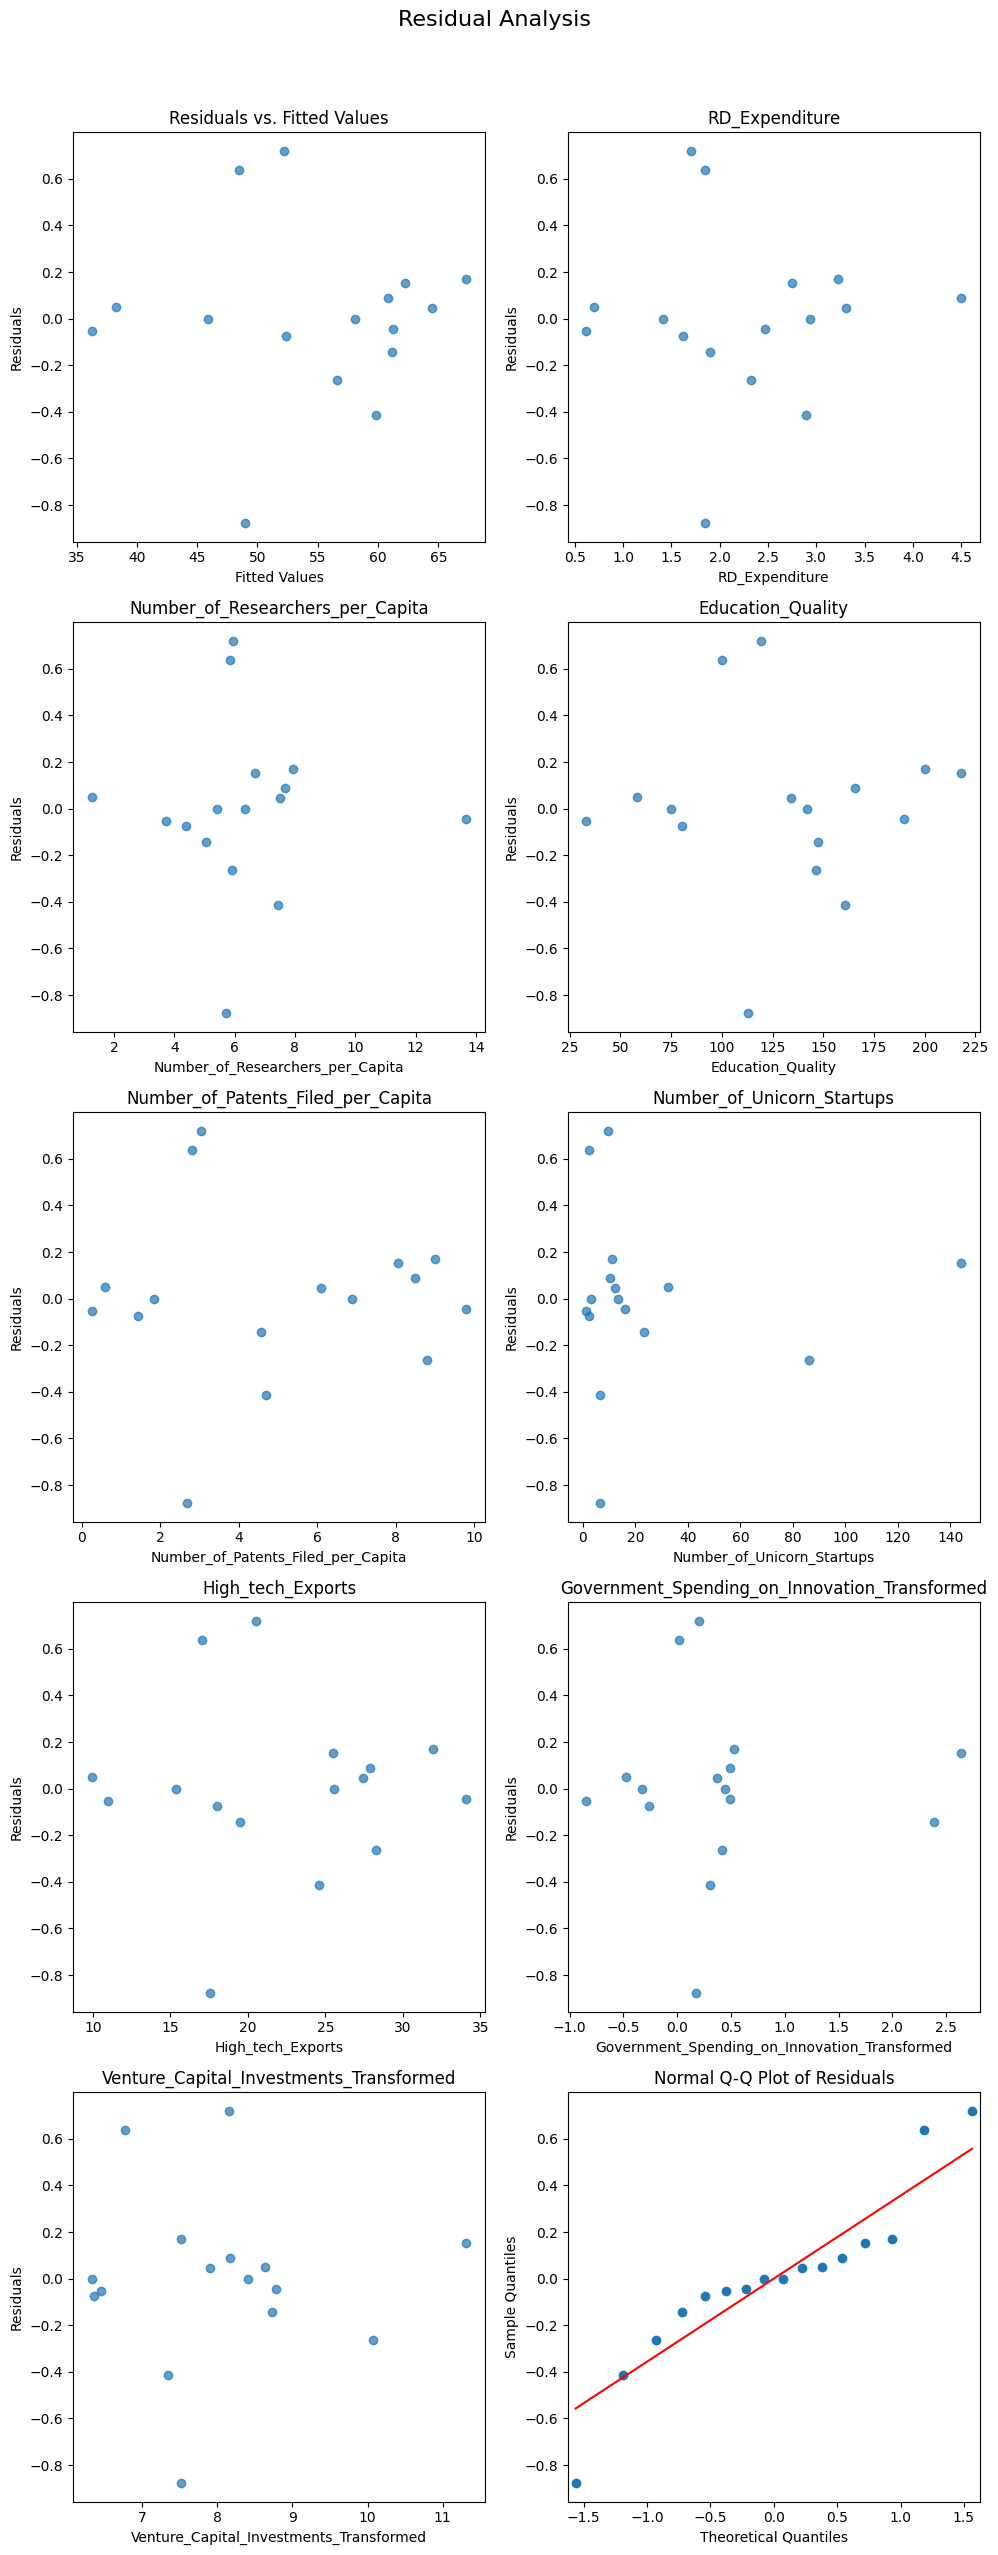

In [ ]:
plot_residuals(model_transformed, df)

# Feature Selection

We only have a few more features than we have countries. Maybe we should consider penalized regression (eg. LASSO) to reduce our number of features.

In [ ]:
def prepare_for_lasso(df, continuous_vars, categorical_vars):
    """
    Prepares a DataFrame for LASSO regression by scaling continuous variables
    and converting categorical variables to dummy variables.

    Args:
        df (pd.DataFrame): The input DataFrame.
        continuous_vars (list): List of names of continuous variables.
        categorical_vars (list): List of names of categorical variables.

    Returns:
        pd.DataFrame: Transformed DataFrame with scaled continuous variables
                      and dummy variables for categorical variables.
    """
    # Scale continuous variables
    scaler = StandardScaler()
    scaled_continuous = pd.DataFrame(
        scaler.fit_transform(df[continuous_vars]),
        columns=continuous_vars,
        index=df.index
    )
    # Make sure categorical variables are of type category
    df[categorical_vars] = df[categorical_vars].astype('category')

    # Convert categorical variables to dummy variables
    dummies = pd.get_dummies(df[categorical_vars], drop_first=False)
    dummies = dummies.astype(int)


    # Combine scaled continuous variables and dummies
    final_df = pd.concat([scaled_continuous, dummies], axis=1)

    return final_df


In [ ]:
categorical_vars = ['Public_Private_Collaboration_Index_Encoded', 'Infrastructure_Readiness_Encoded', 'Knowledge_Diffusion_Encoded', 'Tax_Incentives_for_RD_Encoded']
continuous_vars = [col for col in df.columns if col not in categorical_vars and col != 'Country']
lasso_df = prepare_for_lasso(df, continuous_vars, categorical_vars)
# add countries to lasso
lasso_df['Country'] = df['Country']
lasso_df.columns

Index(['RD_Expenditure', 'Number_of_Researchers_per_Capita',
       'Education_Quality', 'Number_of_Patents_Filed_per_Capita',
       'Number_of_Unicorn_Startups', 'High_tech_Exports',
       'Government_Spending_on_Innovation', 'Venture_Capital_Investments',
       'Innovation_Score', 'Government_Spending_on_Innovation_Transformed',
       'Venture_Capital_Investments_Transformed',
       'Public_Private_Collaboration_Index_Encoded_1',
       'Public_Private_Collaboration_Index_Encoded_2',
       'Public_Private_Collaboration_Index_Encoded_3',
       'Infrastructure_Readiness_Encoded_1',
       'Infrastructure_Readiness_Encoded_2',
       'Infrastructure_Readiness_Encoded_3', 'Knowledge_Diffusion_Encoded_1',
       'Knowledge_Diffusion_Encoded_2', 'Knowledge_Diffusion_Encoded_3',
       'Tax_Incentives_for_RD_Encoded_1', 'Tax_Incentives_for_RD_Encoded_2',
       'Tax_Incentives_for_RD_Encoded_3', 'Country'],
      dtype='object')

In [ ]:
# remove unnecessary variables, including untransformed columns
X = lasso_df.drop(columns=['Innovation_Score', 'Country', 'Venture_Capital_Investments', 'Government_Spending_on_Innovation'])
y = lasso_df['Innovation_Score']

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
model = LassoCV(alphas=arange(0, 1, 0.01), cv=cv, n_jobs=-1)
# fit model
model.fit(X, y)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.902e-03, tolerance: 1.540e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or con

alpha: 0.010000


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.176e-03, tolerance: 1.517e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or con

Looks like alpha = 0.01 is best.

In [ ]:
# define model
lasso_model = Lasso(alpha=0.01)
# fit model
lasso_model.fit(X, y)
# find nonzero coefficients
nonzero_coefficients = np.sum(lasso_model.coef_ != 0)
print(f"Names of non-zero coefficients: {X.columns[lasso_model.coef_ != 0]}")

Names of non-zero coefficients: Index(['RD_Expenditure', 'Number_of_Researchers_per_Capita',
       'Number_of_Patents_Filed_per_Capita', 'Number_of_Unicorn_Startups',
       'High_tech_Exports', 'Government_Spending_on_Innovation_Transformed',
       'Venture_Capital_Investments_Transformed',
       'Public_Private_Collaboration_Index_Encoded_1',
       'Infrastructure_Readiness_Encoded_1',
       'Infrastructure_Readiness_Encoded_3', 'Knowledge_Diffusion_Encoded_1',
       'Tax_Incentives_for_RD_Encoded_1', 'Tax_Incentives_for_RD_Encoded_3'],
      dtype='object')


In [ ]:
# find zero coefficients
zero_coefficients = np.sum(lasso_model.coef_ == 0)
print(f"Names of zero coefficients: {X.columns[lasso_model.coef_ == 0]}")

Names of zero coefficients: Index(['Education_Quality', 'Public_Private_Collaboration_Index_Encoded_2',
       'Public_Private_Collaboration_Index_Encoded_3',
       'Infrastructure_Readiness_Encoded_2', 'Knowledge_Diffusion_Encoded_2',
       'Knowledge_Diffusion_Encoded_3', 'Tax_Incentives_for_RD_Encoded_2'],
      dtype='object')


Looks like features to include are:


*   R&D Expenditure
*   Number of researchers per capita
*   Number of unicorn startups
*   High tech exports
*   Government spending on innovation
*   VC investments
*   Infrastructure readiness
*   Tax incentives
*   Number of patents

And features to remove are

* Education Quality
* Public/private collaboration
* Knowledge Diffusion




Further, from the Random Forest regressor, we see that public-private collaboration index, as well as tax incentives, may be not be too important. However, RF found that Education Quality was very important in prediction, so we will retain that variable for the final model.

Therefore, combining the results of Lasso and RF, the variables Public-private collaboration, Tax Incentives, and Knowledge Diffusion were exluded from the analysis.

Perform OLS

In [ ]:
# Now that we know which to exlude, we can run OLS again.
model_final = ols('Innovation_Score ~ RD_Expenditure + \
Number_of_Researchers_per_Capita + \
Number_of_Patents_Filed_per_Capita + \
Number_of_Unicorn_Startups + \
High_tech_Exports + Government_Spending_on_Innovation_Transformed + \
Venture_Capital_Investments_Transformed  + \
C(Infrastructure_Readiness_Encoded) + \
Education_Quality ', data=df).fit()
model_final.summary()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Innovation_Score   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     61.50
Date:                Sat, 30 Nov 2024   Prob (F-statistic):           0.000134
Time:                        19:46:18   Log-Likelihood:                -18.997
No. Observations:                  16   AIC:                             59.99
Df Residuals:                       5   BIC:                             68.49
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        29.0848      7.322      3.972      0.011      10.263      47.906
C(Infrastructure_Readiness_Encoded)[T.2]          0.4027      2.123      0.190      0.857      -5.054       5.859
C(Infrastructure_Readiness_Encoded)[T.3]         -1.2616      2.032     -0.621      0.562      -6.484       3.961
RD_Expenditure                                    1.5250      0.815      1.872      0.120      -0.570       3.620
Number_of_Researchers_per_Capita                 -1.1532      0.331     -3.481      0.018      -2.005      -0.301
Number_of_Patents_Filed_per_Capita               -2.0298      0.643     -3.158      0.025      -3.682      -0.378
Number_of_Unicorn_Startups                       -0.0194      0.024     -0.804      0.458      -0.082       0.043
High_tech_Exports                                 2.0714      0.326      6.349      0.001       1.233       2.910
Government_Spending_on_Innovation_Transformed     5.6428      0.998      5.653      0.002       3.077       8.209
Venture_Capital_Investments_Transformed          -0.8666      0.844     -1.026      0.352      -3.037       1.304
Education_Quality                                -0.0026      0.030     -0.087      0.934      -0.079       0.074
==============================================================================
Omnibus:                        2.275   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.321   Jarque-Bera (JB):                1.411
Skew:                           0.721   Prob(JB):                        0.494
Kurtosis:                       2.810   Cond. No.                     3.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Optimization

In [ ]:
# Get python list of model parameters
beta = model_final.params.tolist()
rounded_betas = [round(beta, 2) for beta in beta]
rounded_betas

[29.08, 0.4, -1.26, 1.52, -1.15, -2.03, -0.02, 2.07, 5.64, -0.87, -0.0]

In [ ]:
len(beta)

11

In [ ]:
from scipy.optimize import minimize

# Objective function: Maximize Innovation Score (negative for minimization)
min_innovation_score = 50    # For example, lower bound of innovation score
max_innovation_score = 100  # Upper bound of innovation score

def innovation_score(x):
    return -(beta[0] + beta[1]*x[0] + beta[2]*x[1] + beta[3]*x[2] + beta[4]*x[3] + \
             beta[5]*x[4] + beta[6]*x[5]+ beta[7]*x[6] + beta[8]*x[7] + beta[9]*x[8] + beta[10]*x[9])

constraints = [
    {'type': 'ineq', 'fun': lambda x: x[2] + np.exp(x[7]) - 2},  # % of GDP spent on R&D + % GDP on innovation >= 2
    {'type': 'ineq', 'fun': lambda x: 5 - x[2] - np.exp(x[7])},
   # Innovation score >= min_innovation_score
    {'type': 'ineq', 'fun': lambda x: -innovation_score(x) - min_innovation_score},
    # Innovation score <= max_innovation_score
    {'type': 'ineq', 'fun': lambda x: max_innovation_score - (-innovation_score(x))}
]

# Bounds for each variable
bounds = [(0, 1),  (0, 1), # Infrastructure readiness
          (0, 5), # % GDP spent on R&D
          (5, 10), # Researchers per capita
          (3, 10), # Patents per capita
          (9, 15), # Unicorn startups
          (20, 30), # high tech exports
          (0, np.log(5)), # spending on innovation transformed
          (np.log(3000), np.log(5000)), # VC investment transformed
          (119, 160) # Education Quality
         ]

# Initial guess
x0 = [
    0, 1,  # Infrastructure_Readiness_Encoded
    1.7,  # RD_Expenditure
    5.94,  # Number_of_Researchers_per_Capita
    3.04,  # Number_of_Patents_Filed_per_Capita
    9.67,   # Number_of_Unicorn_Startups
    20.55,   # High_tech_Exports
    np.log(1.22),  # Government_Spending_on_Innovation_Transformed
    np.log(3465),  # Venture_Capital_Investments_Transformed
    119.44 # Education quality

]
# Solve optimization
result = minimize(innovation_score, x0, constraints=constraints, bounds=bounds)
#result = minimize(innovation_score, x0)

# Results
if result.success:
    print("Optimal values for features:", result.x)
    print("Maximum innovation score:", -result.fun)
else:
    print("Optimization failed:", result.message)


Optimal values for features: [1.00000000e+00 9.92691045e-13 1.29978630e+00 5.00000000e+00
 3.00000000e+00 9.00000000e+00 3.00000000e+01 1.30839058e+00
 8.00636757e+00 1.19000000e+02]
Maximum innovation score: 81.71758801561641


In [ ]:
optimal_values = result.x

In [ ]:
# Index of the transformed features in optimal_values
gov_spending_index = 7  # Assuming this is the index of Government_Spending_on_Innovation_Transformed
vc_investments_index = 8  # Assuming this is the index of Venture_Capital_Investments_Transformed

# Reverse the log transformation using exponentiation
optimal_values[gov_spending_index] = round(np.exp(optimal_values[gov_spending_index]), 2)  # Round to 2 decimal places
optimal_values[vc_investments_index] = round(np.exp(optimal_values[vc_investments_index]), 2)  # Round to 2 decimal places

In [ ]:
# Round all optimal values to 2 decimal places
optimal_values_rounded = [round(val, 2) for val in optimal_values]

# Print the rounded, non-exponentiated optimal values
print(optimal_values_rounded)

[1.0, 0.0, 1.3, 5.0, 3.0, 9.0, 30.0, 3.7, 3000.0, 119.0]


In [ ]:
# Find baseline score
# add intercept to x0
x0.insert(0, 1)
# Get baseline score of x0 * betas
baseline_score = np.dot(beta, x0)
baseline_score

53.523830996633336

In [ ]:
# Find optimized score
optimized_score = 81.71758801501232

In [ ]:
# Find optimal values
optimal_values = result.x

In [ ]:
# Find baseline values
baseline_values = x0

In [ ]:
# Find betas
beta

[29.084771748917262,
 0.40269771399999854,
 -1.2615845147145883,
 1.5249952002122917,
 -1.1531635395234887,
 -2.029792834773941,
 -0.01943781740580597,
 2.0713942472656814,
 5.642807265090539,
 -0.8665812157175914,
 -0.0025930107277118974]

In [ ]:
# Assuming you have the following:
# - baseline_score: The initial innovation score before optimization.
# - optimized_score: The innovation score after optimization.
# - optimal_values: A list of optimized feature values.
# - baseline_values: A list of initial feature values (x0 in your code).
# - beta: A list of model coefficients.

feature_contributions = []
feature_names = ['RD_Expenditure', 'Number_of_Researchers_per_Capita',
                 'Number_of_Patents_Filed_per_Capita', 'Number_of_Unicorn_Startups',
                 'High_tech_Exports', 'Government_Spending_on_Innovation_Transformed',
                 'Venture_Capital_Investments_Transformed', 'Infrastructure_Readiness_Encoded',
                 'Education_Quality']

for i in range(len(feature_names)):
    contribution = beta[i + 1] * (optimal_values[i] - baseline_values[i + 1])  # +1 to skip intercept in beta
    feature_contributions.append(contribution)

# Calculate the total change due to optimization
total_change = optimized_score - baseline_score

In [ ]:
import plotly.graph_objects as go

# Prepare data for the waterfall chart
features = ['Baseline'] + feature_names + ['Optimized']
contributions = [baseline_score] + feature_contributions + [total_change]

# Create the waterfall chart
fig = go.Figure(go.Waterfall(
    name="Feature Impact",
    orientation="v",
    measure=["absolute"] + ["relative"] * len(feature_names) + ["total"],  # Adjust measures for correct display
    x=features,
    textposition="outside",
    y=contributions,
    connector={"line": {"color": "rgba(63, 63, 63, 0.7)"}},
    text=[str(round(val, 2)) for val in contributions] # Add text labels to display

))


fig.update_layout(title="Feature Impact on Innovation Score",
                  xaxis_title="Features",
                  yaxis_title="Innovation Score",
                  showlegend=True,
                  height=800)

fig.show()

In [ ]:
# Performance metrics
# Predictions
X = df[['RD_Expenditure', 'Number_of_Researchers_per_Capita',
                 'Number_of_Patents_Filed_per_Capita', 'Number_of_Unicorn_Startups',
                 'High_tech_Exports', 'Government_Spending_on_Innovation_Transformed',
                 'Venture_Capital_Investments_Transformed', 'Infrastructure_Readiness_Encoded',
                 'Education_Quality']]
predictions = model_final.predict(X)

# Performance Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

r2 = r2_score(df['Innovation_Score'], predictions)
mae = mean_absolute_error(df['Innovation_Score'], predictions)
mse = mean_squared_error(df['Innovation_Score'], predictions)
rmse = mean_squared_error(df['Innovation_Score'], predictions, squared=False)

print(f"R²: {r2}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

R²: 0.9919348742739624
Mean Absolute Error: 0.6026379564974849
Mean Squared Error: 0.6292080295282129
Root Mean Squared Error: 0.7932263419278339


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
